# Makemore exercices (Part 1)

In [1]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline
words = open('/media/eric/D/datasets/names.txt', 'r').read().splitlines()

## Ex 1
Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

### By counting

In [2]:
# temp dictionary of how we want trigrams
b = {}
for w in words:
	chs = ['.'] + list(w) + ['.']
	for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
		trigram = (ch1, ch2, ch3)
		b[trigram] = b.get(trigram, 0) + 1

sorted(b.items(), key = lambda kv: -kv[1])[:10]

[(('a', 'h', '.'), 1714),
 (('n', 'a', '.'), 1673),
 (('a', 'n', '.'), 1509),
 (('o', 'n', '.'), 1503),
 (('.', 'm', 'a'), 1453),
 (('.', 'j', 'a'), 1255),
 (('.', 'k', 'a'), 1254),
 (('e', 'n', '.'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '.'), 953)]

In [3]:
# mapping of characters to indexes
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
# 3D tensor of counts
N = torch.zeros((27, 27, 27), dtype=torch.int32)
for w in words:
	chs = ['.'] + list(w) + ['.']
	for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
		ix1 = stoi[ch1]
		ix2 = stoi[ch2]
		ix3 = stoi[ch3]
		N[ix1, ix2, ix3] += 1

(-0.5, 26.5, 26.5, -0.5)

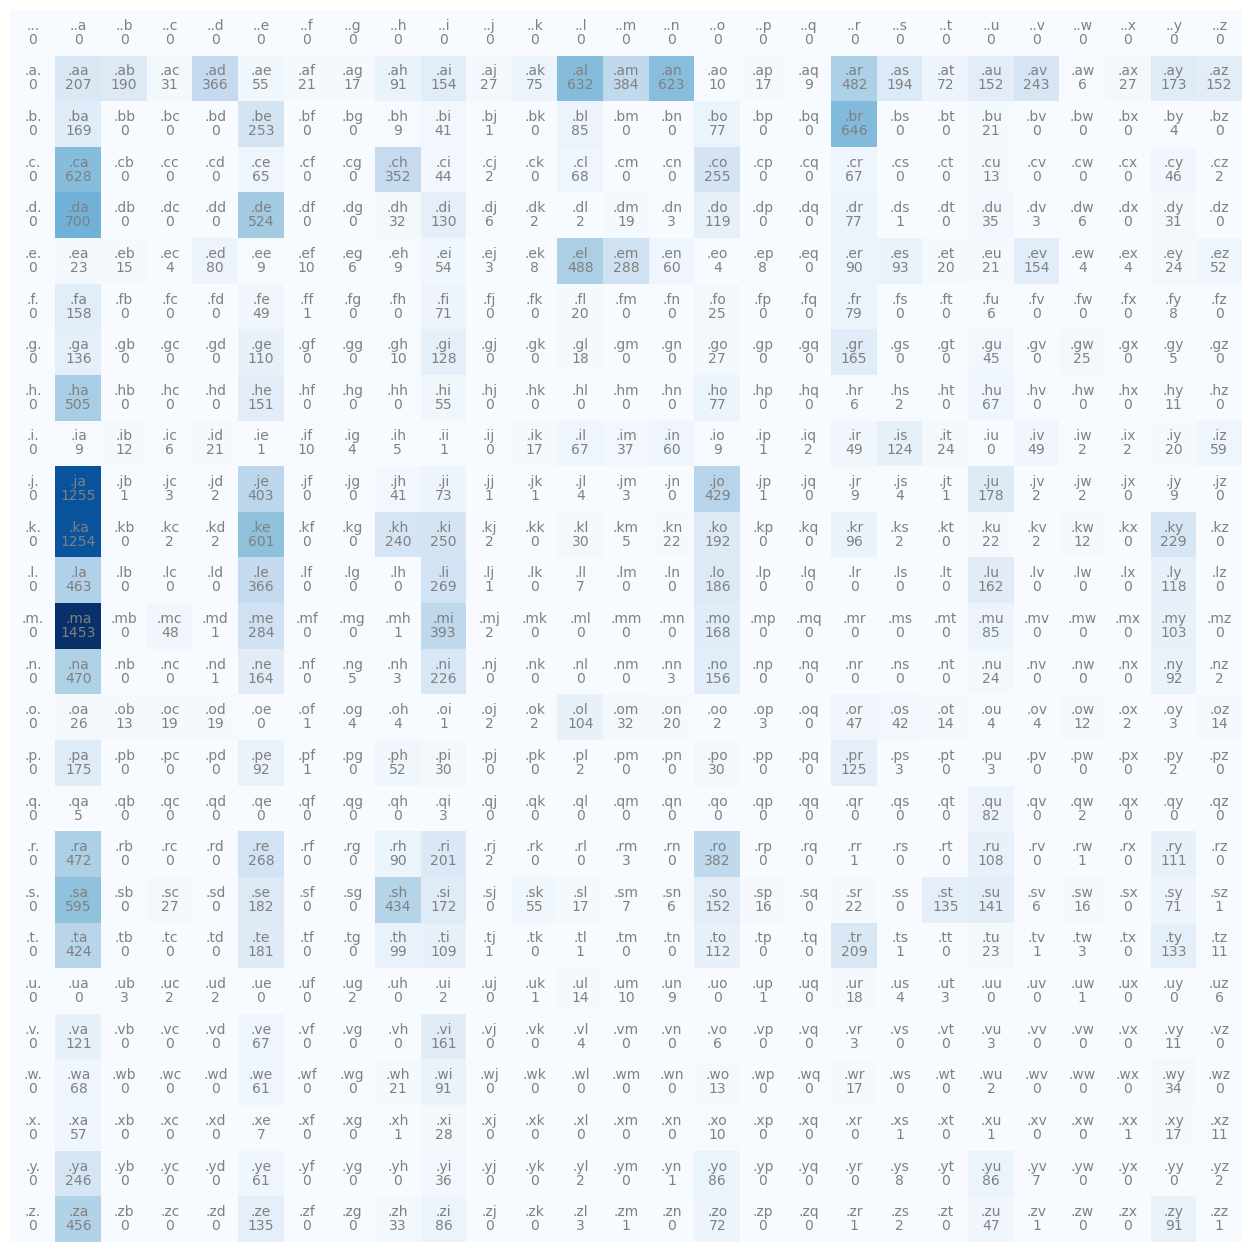

In [5]:
# plot of first 2D slice
plt.figure(figsize=(16,16))
plt.imshow(N[0, :, :], cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[0] + itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[0, i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')

In [6]:
P = (N+1).float()
P /= P.sum(dim=2, keepdim=True)
assert torch.allclose(P.sum(dim=2), torch.ones(27, 27))
print("Correct")

Correct


In [7]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
	ix1, ix2 = 0, torch.randint(1, 27, (1,), generator=g).item()
	print(itos[ix2], end='')
	while True:
		p = P[ix1, ix2]
		ix1 = ix2
		ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		print(itos[ix2], end='')
		if ix2 == 0:
			break
	print()

nuojde.
ulianah.
yulfra.
elin.
corin.
lolian.
pree.
adiania.
yanileniassibduinrwin.
passiyanayla.


In [8]:
log_likelihood = 0.0
n = 0

for w in words:
	chs = ['.'] + list(w) + ['.']
	for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
		ix1 = stoi[ch1]
		ix2 = stoi[ch2]
		ix3 = stoi[ch3]
		prob = P[ix1, ix2, ix3]
		logprob = torch.log(prob)
		log_likelihood += logprob
		n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood 
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-410414.9688)
nll=tensor(410414.9688)
2.092747449874878


### By Neural Net

In [9]:
# create the dataset
xs1, xs2, ys = [], [], []
for w in words:
	chs = ['.'] + list(w) + ['.']
	for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
		ix1 = stoi[ch1]
		ix2 = stoi[ch2]
		ix3 = stoi[ch3]
		xs1.append(ix1)
		xs2.append(ix2)
		ys.append(ix3)
xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)
num = xs1.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

number of examples:  196113


In [10]:
# gradient descent
for k in range(100):

	# forward pass
	xenc = F.one_hot(xs1, num_classes=27).float()
	xenc = torch.cat((xenc, F.one_hot(xs2, num_classes=27).float()), dim=1)
	logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
	if k%10==0: print(loss.item())
	
	# backward pass
	W.grad = None
	loss.backward()

	# update
	W.data += -50 * W.grad

4.1959710121154785
2.51039719581604
2.38606595993042
2.3393921852111816
2.3152151107788086
2.300726890563965
2.2911763191223145
2.2844254970550537
2.2794029712677
2.275524616241455


In [11]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
	
	out = []
	ix1, ix2 = 0, torch.randint(1, 27, (1,), generator=g).item()
	print(itos[ix2], end='')
	while True:
		xenc = F.one_hot(torch.tensor([ix1]), num_classes=27).float()
		xenc = torch.cat((xenc, F.one_hot(torch.tensor([ix2]), num_classes=27).float()), dim=1)
		logits = xenc @ W
		counts = logits.exp()
		p = counts / counts.sum(1, keepdims=True)
		
		ix1 = ix2
		ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
		print(itos[ix2], end='')
		if ix2 == 0:
			break
	print()

nuwide.
uliasad.
yan.
ma.
elin.
corin.
lohia.
uathe.
adannaauranileniassibdainrwi.
alys.


## Ex 2
Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [12]:
from torch.utils.data import random_split

# randomly split words into training, dev and test sets
g = torch.Generator().manual_seed(2147483647)
train, dev, test = random_split(words, [0.8, 0.1, 0.1], generator=g)

### Bigram

In [24]:
def get_xy_bi(_words):
	xs, ys = [], []
	for w in _words:
		chs = ['.'] + list(w) + ['.']
		for ch1, ch2 in zip(chs, chs[1:]):
			xs.append(stoi[ch1])
			ys.append(stoi[ch2])
	return torch.tensor(xs), torch.tensor(ys)

# create the datasets
train_xs, train_ys = get_xy_bi(train)
dev_xs, dev_ys = get_xy_bi(dev)
test_xs, test_ys = get_xy_bi(test)

# Initialize the network
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [14]:
# gradient descent
for k in range(200):
	
	# forward pass
	xenc = F.one_hot(train_xs, num_classes=27).float()
	logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(train_xs.nelement()), train_ys].log().mean() + 0.01*(W**2).mean()
	if k%10==0: print(loss.item())
	
	# backward pass
	W.grad = None
	loss.backward()
	
	# update
	W.data += -50 * W.grad

3.6887640953063965


2.6740610599517822
2.57535982131958
2.5382206439971924
2.519714593887329
2.508991003036499
2.5021536350250244
2.4974937438964844
2.494166612625122
2.491710901260376
2.489851951599121
2.4884142875671387
2.4872820377349854
2.4863762855529785
2.485639810562134
2.485034465789795
2.484529733657837
2.484105348587036
2.4837448596954346
2.4834351539611816


In [15]:
def evaluate(_xs, _ys):
	xenc = F.one_hot(_xs, num_classes=27).float()
	logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(_xs.nelement()), _ys].log().mean()
	return loss.item()

# evaulate on the dev set
print(evaluate(dev_xs, dev_ys))

# evaulate on the test set
print(evaluate(test_xs, test_ys))

2.464423656463623
2.4648733139038086


### Trigram

In [25]:
def get_xy_tri(_words):
	xs1, xs2, ys = [], [], []
	for w in _words:
		chs = ['.'] + list(w) + ['.']
		for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
			xs1.append(stoi[ch1])
			xs2.append(stoi[ch2])
			ys.append(stoi[ch3])
	return torch.tensor(xs1), torch.tensor(xs2), torch.tensor(ys)

# create the datasets
train_xs1, train_xs2, train_ys = get_xy_tri(train)
dev_xs1, dev_xs2, dev_ys = get_xy_tri(dev)
test_xs1, test_xs2, test_ys = get_xy_tri(test)

# Initialize the network
def initialize():
	return torch.randn((27*2, 27), generator=g, requires_grad=True)
W = initialize()

In [17]:
def fit(iterations=200, lr=50, l2=0.01):
	losses = []
	# gradient descent
	for k in range(iterations):

		# forward pass
		xenc = F.one_hot(train_xs1, num_classes=27).float()
		xenc = torch.cat((xenc, F.one_hot(train_xs2, num_classes=27).float()), dim=1)
		logits = xenc @ W
		counts = logits.exp()
		probs = counts / counts.sum(1, keepdims=True)
		loss = -probs[torch.arange(train_xs1.nelement()), train_ys].log().mean() + l2*(W**2).mean()
		losses.append(loss.item())
		if k%10==0: print(loss.item())
		
		# backward pass
		W.grad = None
		loss.backward()

		# update
		W.data += -lr * W.grad
	return losses

losses = fit()

4.3484368324279785


2.496084213256836
2.3819234371185303
2.33880877494812
2.3161990642547607
2.302172899246216
2.2925868034362793
2.2856345176696777
2.2803943157196045
2.2763330936431885
2.27311635017395
2.270519733428955
2.26839017868042
2.2666192054748535
2.2651283740997314
2.263859987258911
2.2627713680267334
2.2618284225463867
2.261005401611328
2.2602827548980713


In [18]:
def evaluate(_xs1, _xs2, _ys):
	xenc = F.one_hot(_xs1, num_classes=27).float()
	xenc = torch.cat((xenc, F.one_hot(_xs2, num_classes=27).float()), dim=1)
	logits = xenc @ W
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(_xs1.nelement()), _ys].log().mean()
	return loss.item()

# evaulate on the dev set
print(evaluate(dev_xs1, dev_xs2, dev_ys))

# evaulate on the test set
print(evaluate(test_xs1, test_xs2, test_ys))

2.2560088634490967
2.2471044063568115


## Ex 3
Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [19]:
train_losses = {}
dev_losses = {}
ws = {}
params = [0.001, 0.01, 0.1, 1, 10]

for l2 in params:
	print(f"{l2=}")
	W = initialize()
	train_losses[l2] = fit(100, l2=l2)
	dev_losses[l2] = evaluate(dev_xs1, dev_xs2, dev_ys)
	ws[l2] = W

l2=0.001
4.186692714691162
2.5106520652770996
2.382585287094116
2.335164785385132
2.3103480339050293
2.2951672077178955
2.284986972808838
2.277719736099243
2.272289991378784
2.268087148666382
l2=0.01
4.201225757598877
2.5041704177856445
2.3844387531280518
2.338740825653076
2.3149406909942627
2.3006887435913086
2.2912893295288086
2.284630537033081
2.279664993286133
2.2758243083953857
l2=0.1
4.518169403076172
2.547114610671997
2.428576946258545
2.3862318992614746
2.364388942718506
2.351362943649292
2.342907428741455
2.3370907306671143
2.3329250812530518
2.3298583030700684
l2=1
5.129053592681885
2.711242437362671
2.5725386142730713
2.5504631996154785
2.546457529067993
2.5456786155700684
2.545520305633545
2.545487403869629
2.545480251312256
2.5454788208007812
l2=10
14.038252830505371
2.991224765777588
2.9899752140045166
2.989626407623291
2.9895124435424805
2.989473819732666
2.9894602298736572
2.9894559383392334
2.9894540309906006
2.9894535541534424


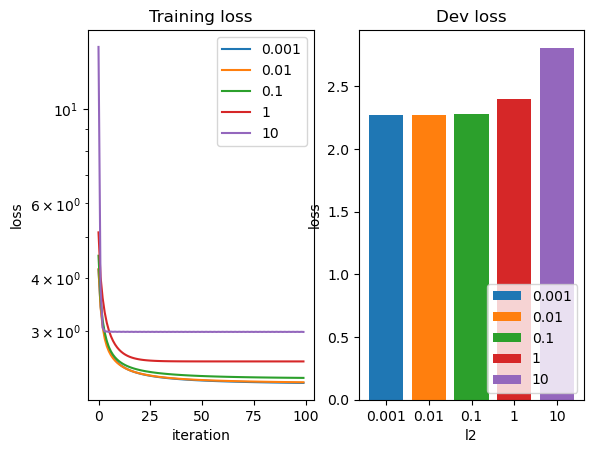

In [20]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Training loss')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].set_yscale('log')
ax[1].set_title('Dev loss')
ax[1].set_xlabel('l2')
ax[1].set_ylabel('loss')
for l2 in params:
	ax[0].plot(train_losses[l2], label=str(l2))
	ax[1].bar(str(l2), dev_losses[l2], label=str(l2))
ax[0].legend()
ax[1].legend(loc='lower right')
plt.show()

In [21]:
best_l2 = min(dev_losses, key=dev_losses.get)
best_l2

0.01

In [22]:
W = ws[best_l2]
print(evaluate(test_xs1, test_xs2, test_ys))

2.261532783508301


## Ex 4
We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

### Bigram

In [75]:
# create the datasets
train_xs, train_ys = get_xy_bi(train)
dev_xs, dev_ys = get_xy_bi(dev)
test_xs, test_ys = get_xy_bi(test)

# Initialize the network
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [76]:
W.shape, train_xs.shape

(torch.Size([27, 27]), torch.Size([182591]))

In [77]:
train_xs[1]

tensor(23)

In [78]:
W[train_xs].shape

torch.Size([182591, 27])

In [79]:
# gradient descent
for k in range(100):
	
	# forward pass
	logits = W[train_xs]
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(train_xs.nelement()), train_ys].log().mean() + 0.01*(W**2).mean()
	if k%10==0: print(loss.item())
	
	# backward pass
	W.grad = None
	loss.backward()
	
	# update
	W.data += -50 * W.grad

3.876260757446289


2.6720497608184814
2.5713419914245605
2.5363357067108154
2.518944025039673
2.508737087249756
2.502140998840332
2.4975974559783936
2.494323253631592
2.491884231567383


### Trigram

In [107]:
# create the datasets
train_xs1, train_xs2, train_ys = get_xy_tri(train)
dev_xs1, dev_xs2, dev_ys = get_xy_tri(dev)
test_xs1, test_xs2, test_ys = get_xy_tri(test)

# Initialize the network
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

In [108]:
W.shape, train_xs1.shape, W[train_xs1].shape

(torch.Size([54, 27]), torch.Size([156964]), torch.Size([156964, 27]))

In [109]:
(W[train_xs1] + W[27+train_xs2]).shape

torch.Size([156964, 27])

In [110]:
# gradient descent
for k in range(100):

	# forward pass
	logits = W[train_xs1] + W[27+train_xs2]
	counts = logits.exp()
	probs = counts / counts.sum(1, keepdims=True)
	loss = -probs[torch.arange(train_xs1.nelement()), train_ys].log().mean() + 0.001*(W**2).mean()
	if k%10==0: print(loss.item())
	
	# backward pass
	W.grad = None
	loss.backward()

	# update
	W.data += -50 * W.grad

4.319624900817871
2.4807846546173096
2.3680202960968018
2.325582504272461
2.3037540912628174
2.290325164794922
2.281123399734497
2.274416446685791
2.26934552192688
2.265411376953125


## Ex 5
Look up and use **F.cross_entropy** instead of **average negative log likelihood**. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [112]:
# create the datasets
train_xs1, train_xs2, train_ys = get_xy_tri(train)
dev_xs1, dev_xs2, dev_ys = get_xy_tri(dev)
test_xs1, test_xs2, test_ys = get_xy_tri(test)

# Initialize the network
W = torch.randn((27*2, 27), generator=g, requires_grad=True)

# gradient descent
for k in range(100):

	# forward pass
	logits = W[train_xs1] + W[27+train_xs2]
	loss = F.cross_entropy(logits, train_ys) + 0.001*(W**2).mean()
	if k%10==0: print(loss.item())
	
	# backward pass
	W.grad = None
	loss.backward()

	# update
	W.data += -50 * W.grad

4.234798431396484
2.4676434993743896
2.3654654026031494
2.32561993598938
2.304084300994873
2.2906906604766846
2.2815792560577393
2.274984359741211
2.2699968814849854
2.2661006450653076


`cross_entropy` combines Log Softmax (the two lines computing `counts` and `probs`) and NLL on a single function. It's preferred because of its **numerical stability**, it's more **compact** and simplifies the neural net architecture and can be more **efficient**.